# Implementing Quantum Collapse Algorithm on Quantum Computers

The Quantum Collapse Algorithm is a generalized version of the Wave Function Collapse Algorithm and the Discrete Model Synthesis algorithm. The Wave Function Collapse Algorithm's name is inspired by the quantum like features of the algorithm such as superposition. The quantum like features of the algorithm made me want to see if the algorithm could be implemented on a quantum computer. Let's define the Quantum Collapse Algorithm in a high level overview and then seperate out the different parts of the algorithm and implement each part on a quantum computer. And then lets combine those parts to create a complete quantum computing implementation of the Quantum Collapse algorithm.

### Quantum Collapse Algorithm
The algorithm's goal is to create a randomly generate output that obeys a neighborhood contraint. The algorithm initilizes each part of the output to be in a super position of all possible states that is provided by some user input. Then the algorithm iteratively chooses an output part and then it collapse to one state based on its super position and then the superposition of the other parts in the output are updated based on the neighborhood constraint.
```
input <- user define values for possible states to collapse to, output size, neighborhood, neighborhood constraint

neighborhood <- get_neighborhood(input)
neighborhood_constraint <- create_c_n(input)
output <- multidimensional_array(input)
propagation_queue <- queue()

while not_fully_collapsed(output):
    output_part = choose_uncollapsed_part(output)
    collapse(output_part)
    propagation_queue.add(output_part)
    while not empty(propagation_queue):
        v = propagation_queue.pop()
        for n in get_neighbors(v, neighborhood):
            udpated = update_allowed_states(v, n, neighborhood_constraint)
            if updated == True;
                propagation_queue.add(n)
```


Creating a quantum computing algorithm means creating a algorithm that can run on a Quantum Circuit. Although Quantum Computing allows a programmer to compute using super positions, the output of quantum circuits will always be to a collapsed state (not in superposition). The only states that a qubit will collapse to are 0 or 1, a binary collapse. So whatever algorithm that is implemented on a quantum circuit will need to be decode from a binary representation. The output of the Quantum Collapse Algorithm is an multidimensional array where each element of the array is some state from a list of user defined states.

Let's start by representing the states in binary. If a user inputs some set of states, S, then each state can be uniquely paired with some integer. That means the more states there are the more qubits that are needed to represent those states. But the number of qubits needed for each state increases logarithmically since the number of states increases exponentially with each qubit added (i.e. To represent 4 states 2 qubits are needed and to represent 1,024 states 10 qubits are needed).

To represent 16 different states a minimum of 4.0 qubits is needed.


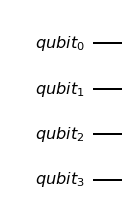

In [1]:
import math

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# 16 possible states
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
num_states = len(states)

# create a circuit with 4 qubits to represent 16 states
num_qubits = math.log2(num_states)
qr = QuantumRegister(num_qubits, 'qubit')

circuit = QuantumCircuit(qr)

print(f"To represent {num_states} different states a minimum of {num_qubits} qubits is needed.")

circuit.draw(output='mpl')

This circuit above shows how many qubits would be needed to represent each state. To actually get an output the circuits needs to have measurements performed on them.

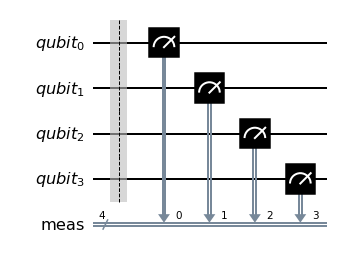

In [2]:
# add measurments to each circuit
circuit.measure_all()

circuit.draw(output='mpl')

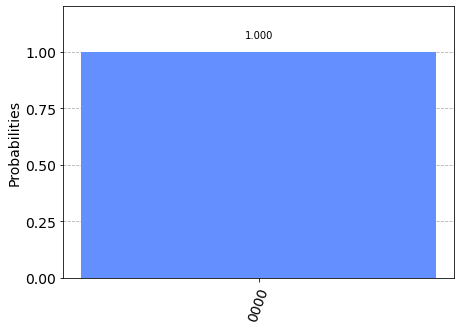

In [3]:
from qiskit import Aer, assemble, transpile
from qiskit.visualization import plot_histogram

sim = Aer.get_backend('aer_simulator')

def run_circuit_on_sim(circuit, num_runs):
    # compile the circuit to run on the simulator
    transpiled_qc = transpile(circuit, sim)
    qobj = assemble(transpiled_qc)

    # run the circuit 1024 times
    result = sim.run(qobj, shots=num_runs).result()
    
    return result

result = run_circuit_on_sim(circuit, num_runs=1024)

plot_histogram(result.get_counts())

Our circuit works in the sense that it gives us an output but the output is always b0000 and we want to get a variety of outputs. The Quantum Collapse algorithm is meant to randomly generate different outputs so we need our circuit to be able to output multiple states. By default qubits on a circuit are intialized, set values on the lefft of the circuit, to 0. These qubits are not in a superposition. To put them in a super position let's apply the hadamar gate before measuring the circuit.

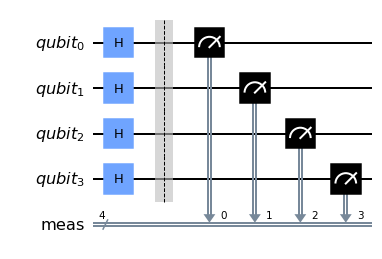

In [4]:
qr = QuantumRegister(num_qubits, 'qubit')

circuit = QuantumCircuit(qr)

circuit.h(qr)
circuit.measure_all()

circuit.draw(output='mpl')

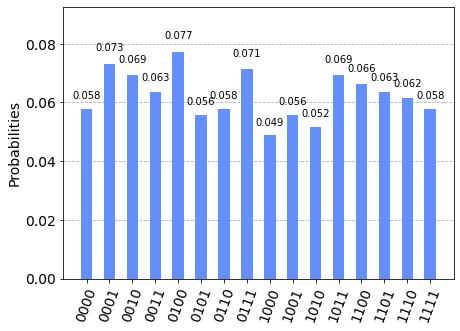

In [5]:
result = run_circuit_on_sim(circuit, num_runs=1024)

plot_histogram(result.get_counts())

Now all states are possible outputs of the circuit, but this circuit only outputs a single state out of 16 possible states and the user can define the output to be of variable size. We could iterively loop through the output and assign a state for each output part but let's avoid relying on classcial computing, we want to use the power of quantum computing. To represent multiple output states simply stack more qubits. So in the circuit above 4 more circuits would be needed to represent a total of 2 output parts.

total circuits = len(output) * log2(num_states)

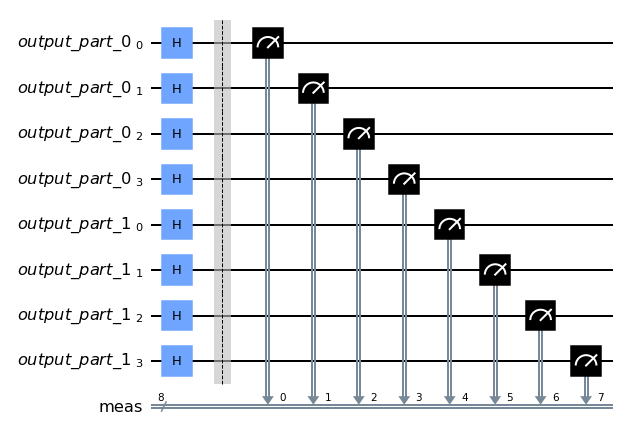

In [6]:
# output of size 2
output = [None, None]

output_part_qubits = [QuantumRegister(num_qubits, f'output_part_{i} ') for i in range(len(output))]

circuit = QuantumCircuit(*output_part_qubits)
for opc in output_part_qubits:
    circuit.h(opc)
circuit.measure_all()

circuit.draw(output='mpl')

We now can create a circuit that can create an output of any size for any number of states. If we wanted to complete the Quantum Collapse Algortihm at this step we would have to randomly generate outputs until a valid output that obeys the neighborhood constraint is found. Again that would mean leaning on classical computing and not seeing any benefit of a quantum computer. So next step is implement the neighborhood constraint on the quantum circuit. The code belows shows how to build a neighborhood contraint in quantum circuit. This is done by using controlled gates. In the example below if output_1 is 00 and output 2 is 01 then the nneighborhood contraint 0 circuit will be 1 if the states of the qubits start of as zero.

In [7]:
# import project code
import sys  
sys.path.insert(0, '..')

from itertools import zip_longest

import numpy as np
from qiskit import ClassicalRegister, Aer, transpile, assemble

from qca import feasible_on_neighborhood_constraint
from qca.input import create_neighborhood_constraint_from_example
from qca.quantum_computing import build_quantum_collapse_algorithm_circuit, build_quantum_collapse_grover_search_circuit, set_quantum_collapse_algorithm_superposition, build_neighbor_constraint_circuit
from qca.quantum_computing import flatten

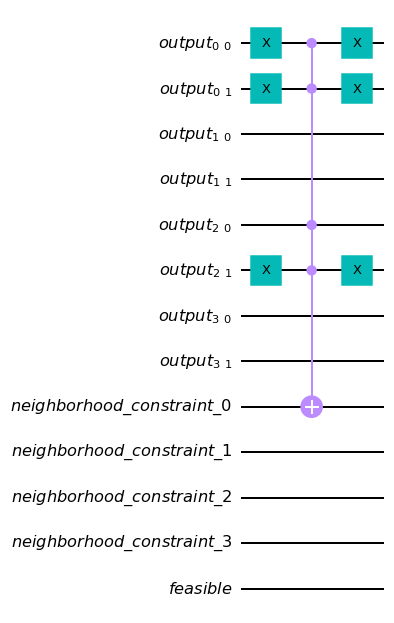

In [8]:
states = np.array(['🟥', '🟦', '🟩', '⬛'])

input_example = np.array([
    ['🟥', '🟥', '🟦'],
    ['🟥', '⬛', '🟦'],
    ['🟥', '🟩', '⬛']
])

neighborhood = [(0, 1), (1, 0)]

output = np.full((2,2, states.size), -1)

circuit, (output_qrs, output_part_qr_mapping), (neighborhood_constraint_qrs, neighborhood_constraint_output_mapping), _ = build_quantum_collapse_algorithm_circuit(states, neighborhood, output)

# [(output_qrs[0], 0), (output_qrs[1], 1)] -> (qubits_1, state), (qubits_2, state)
example_circuit = build_neighbor_constraint_circuit(circuit, [(output_qrs[0], 0), (output_qrs[2], 1)], neighborhood_constraint_qrs[0])

example_circuit.draw(output='mpl')

The last circuit that is needed is the feasible circuit which checks if all neighbordhood contraints are met. Now we can use Grover's algorithm by umcomputing the nieghborhood constraint gates and leaving the feasible circuit computed. Then apply a diffuser on the output qubits so that the output qubits are more likely be a feasible output.

In [9]:
#helper function 
# example: grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx
def grouper(n, iterable, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

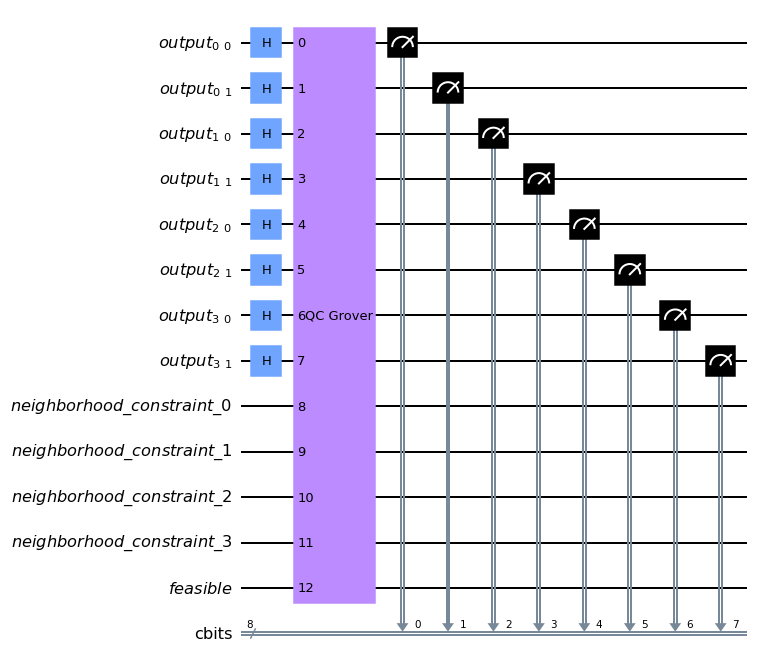

In [10]:
set_quantum_collapse_algorithm_superposition(circuit, output_qrs)

C_n = create_neighborhood_constraint_from_example(states, input_example, neighborhood)

qc_grover = build_quantum_collapse_grover_search_circuit(circuit, C_n, output_qrs, neighborhood_constraint_qrs, neighborhood_constraint_output_mapping, num_iterations=4, to_gate=True)

circuit.append(qc_grover, circuit.qubits)

cbits = ClassicalRegister(len(output_qrs) * output_qrs[0].size, name='cbits')
circuit.add_register(cbits)

circuit.measure(flatten([qubits for qubits in output_qrs]), cbits._bits)

circuit.draw(output='mpl')

The cricuit above does one iteration of Grover's aglorithm. Adding more QC Grover gates would increase the probablity of getting a feasible state.

In [11]:
output_assignments = np.full((2,2), -1, dtype=object)

sim=Aer.get_backend('aer_simulator')

transpiled_qc = transpile(circuit, sim)
qobj = assemble(transpiled_qc)
result = sim.run(qobj, shots=1).result()

counts = result.get_counts()
value_str = list(counts.keys())[0]

# if hex string then convert to binary string
if 'x' in value_str:
    value = int(value_str, 16)
    value_str = ''.join(str(i) for i in to_binary(value, num_bits=8))

num_bits_per_state = int(len(value_str) / len(output_part_qr_mapping))

bit_group_iter = list(grouper(num_bits_per_state, value_str))
bit_group_iter = reversed(bit_group_iter)

for oqr_i, bits in enumerate(bit_group_iter):
    bit_str = ''.join(bits)
    state = int(bit_str, 2)

    output_assignments[output_part_qr_mapping[oqr_i]] = state
    
feasible = feasible_on_neighborhood_constraint(output_assignments, C_n, neighborhood)
for i in range(2):
    for j in range(2):
        output_assignments[i][j] = states[output_assignments[i][j]]
        
print('Feasible output? ', feasible)
print(output_assignments)

Feasible output?  True
[['⬛' '🟦']
 ['🟩' '⬛']]


You can run the step above multiple times and you should eventually get an output that is feasiable. So voilà the quantum collapse algorithm has been built. Try increasing the number of interations, say 4, in the build_quantum_collapse_grover_search_circuit function above to increase the likelyhood of getting a feasible output. Make sure to also re built the circuit in 